1. Install Dependences

In [2]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from flask import Flask, request, render_template

In [3]:
# Set the path to your dataset folder
dataset_path = 'SKC'

In [4]:
# Define the categories (subfolders in the dataset folder)
categories = ['basal cell carcinoma', 'melanoma', 'squamous cell carcinoma']

In [5]:
# Define the image dimensions
IMG_SIZE = 224

In [6]:
# Load the dataset
data = []
labels = []

for category in categories:
    folder_path = os.path.join(dataset_path, category)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        data.append(img)
        labels.append(category)

In [7]:
# Convert the data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

In [8]:
# Encode the labels to numerical class indices
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [9]:
# Convert the labels to categorical
labels = to_categorical(labels)


In [10]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [11]:
# Normalize the pixel values between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [12]:
# Build the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))

In [13]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [14]:
# Data augmentation
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                             zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')


In [15]:
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)


In [16]:
# Train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=10,
                    validation_data=(x_test, y_test), callbacks=[early_stop, checkpoint])


Epoch 1/10
27/27 [==============================] - ETA: 0s - loss: 1.1826 - accuracy: 0.4281
Epoch 1: val_accuracy improved from -inf to 0.38756, saving model to best_model.h5
27/27 [==============================] - 320s 11s/step - loss: 1.1826 - accuracy: 0.4281 - val_loss: 1.0600 - val_accuracy: 0.3876
Epoch 2/10
27/27 [==============================] - ETA: 0s - loss: 1.0335 - accuracy: 0.4424
Epoch 2: val_accuracy improved from 0.38756 to 0.41148, saving model to best_model.h5
27/27 [==============================] - 171s 6s/step - loss: 1.0335 - accuracy: 0.4424 - val_loss: 1.0240 - val_accuracy: 0.4115
Epoch 3/10
27/27 [==============================] - ETA: 0s - loss: 1.0184 - accuracy: 0.4700
Epoch 3: val_accuracy did not improve from 0.41148
27/27 [==============================] - 259s 10s/step - loss: 1.0184 - accuracy: 0.4700 - val_loss: 1.0611 - val_accuracy: 0.3971
Epoch 4/10
27/27 [==============================] - ETA: 0s - loss: 1.0455 - accuracy: 0.4269
Epoch 4: val

In [17]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

7/7 [==============================] - 26s 4s/step - loss: 1.0643 - accuracy: 0.4067
Test accuracy: 0.4066985547542572


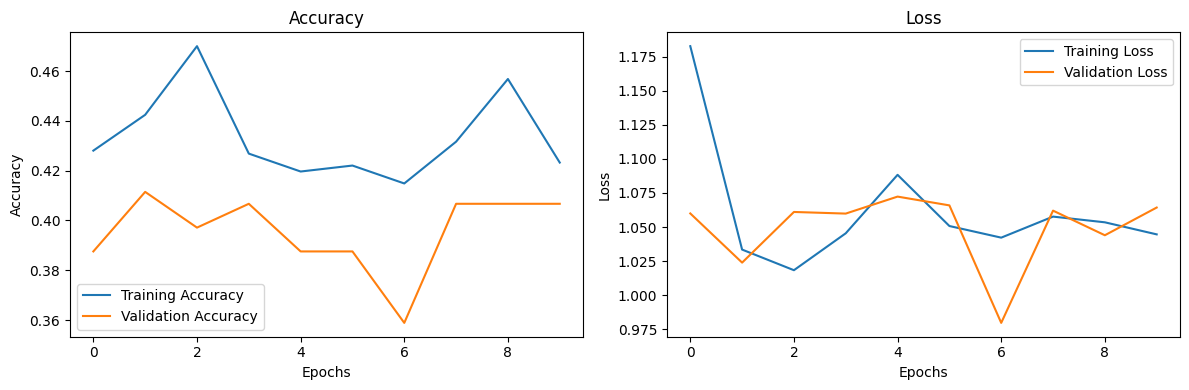

In [18]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
#Load the best saved model
best_model = load_model('best_model.h5')

In [20]:
#Make predictions on test data
predictions = best_model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)

7/7 [==============================] - 34s 4s/step


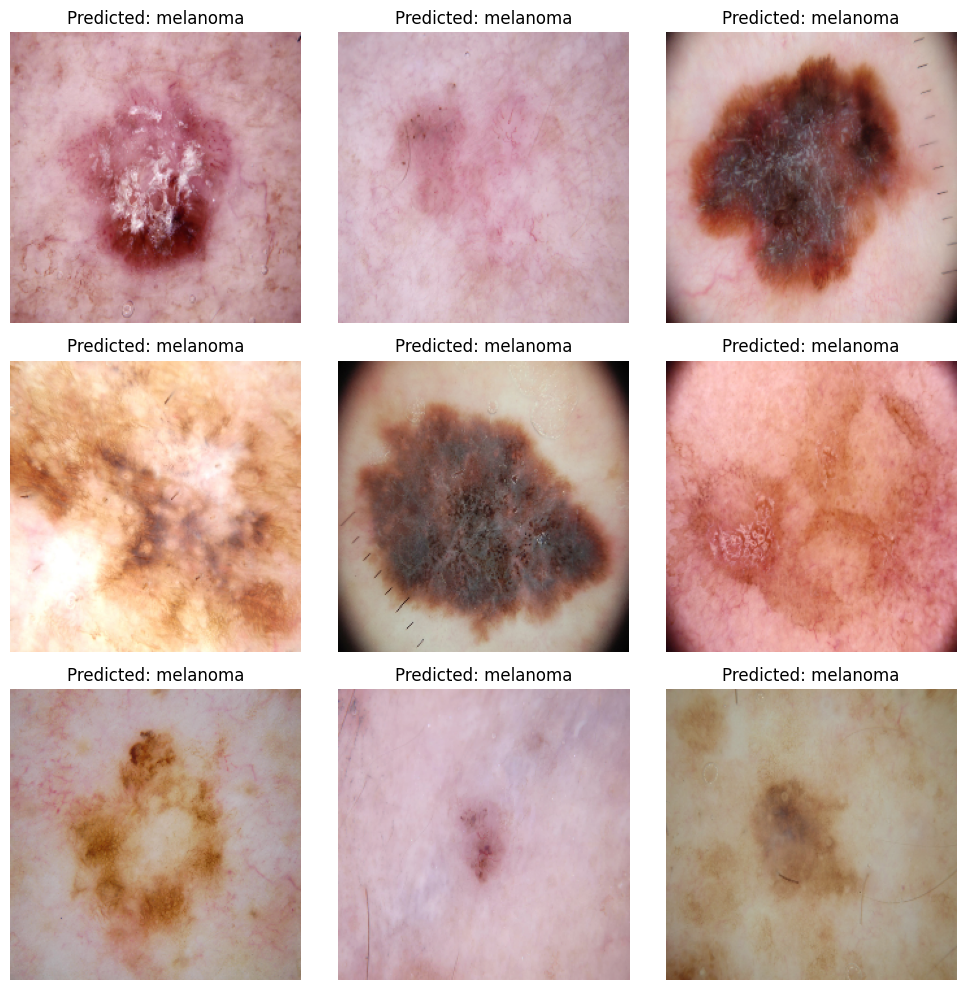

In [30]:
#Display a few sample images with their predicted labels
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for i in range(9):
    axes[i].imshow(x_test[i])
    axes[i].set_title(f"Predicted: {categories[predicted_labels[i]]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [22]:
# Initialize Flask application
app = Flask(__name__)

In [23]:
# Define the image size
IMG_SIZE = 224

In [24]:
# Define the categories (subfolders in the dataset folder)
categories = ['basal cell carcinoma', 'melanoma', 'squamous cell carcinoma']

In [25]:
# Define the upload folder
UPLOAD_FOLDER = 'uploads'
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

In [26]:
# Function to preprocess the uploaded image
def preprocess_image(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    return img

In [27]:
# Route for home page
@app.route('/')
def home():
    return render_template('index.html')


In [28]:
# Route to handle image upload and classification
@app.route('/upload', methods=['POST'])
def handle_upload():
    # Check if a file was uploaded
    if 'image' not in request.files:
        return render_template('index.html', error='No image file selected.')
    
    file = request.files['image']
    
    # Check if the file is empty
    if file.filename == '':
        return render_template('index.html', error='No image file selected.')
    
    # Check if the file has an allowed extension
    if not allowed_file(file.filename):
        return render_template('index.html', error='Invalid file extension.')
    
    # Save the uploaded file to the upload folder
    file_path = os.path.join(app.config['UPLOAD_FOLDER'], file.filename)
    file.save(file_path)
    
    # Load and preprocess the uploaded image
    image = cv2.imread(file_path)
    preprocessed_image = preprocess_image(image)
    
    # Make a prediction on the preprocessed image
    prediction = best_model.predict(preprocessed_image)
    predicted_label = categories[np.argmax(prediction)]
    
    # Pass the predicted label to the template for display
    return render_template('index.html', image=file.filename, predicted_label=predicted_label)


In [29]:
# Function to check if the file has an allowed extensionS
def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in {'jpg', 'jpeg', 'png'}

# Run the Flask application
if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [28/May/2023 08:59:35] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2023 08:59:35] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2023 08:59:37] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [28/May/2023 08:59:37] "GET /favicon.ico HTTP/1.1" 404 -
[2023-05-28 09:00:15,361] ERROR in app: Exception on /upload [POST]
Traceback (most recent call last):
  File "c:\Users\ADEBOSS\AppData\Local\Programs\Python\Python311\Lib\site-packages\flask\app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ADEBOSS\AppData\Local\Programs\Python\Python311\Lib\site-packages\flask\app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ADEBOSS\AppData\Local\Programs\Python\Python311\Lib\site-packages\flask\app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_